In [1]:
import configparser
import pandas as pd
import theano
import theano.gpuarray
theano.gpuarray.use("cuda" + str(0))
from nolearn.lasagne import visualize
import matplotlib.pyplot as plt
import numpy as np
from numpy import genfromtxt
import pygpu
from pygpu import gpuarray
from six.moves import cPickle
import os
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1 import make_axes_locatable
import statistics as stats
import glob
from texttable import Texttable
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation

#import matplotlib
#matplotlib.use('Agg')

import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

#from utils.util import plot_confusion
#import utils.generate as gen

import copy
#import generate
import numpy as np
from sklearn import metrics
import pandas as pd
#import matplotlib.pyplot as plt
import seaborn
import keras
import keras.backend.tensorflow_backend as K
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dropout
from keras.layers import Dense
from keras.layers import Flatten
from keras.engine.topology import Input
from keras.optimizers import Adam
from keras import regularizers
from keras.models import load_model
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

import lasagne

from vis.visualization import visualize_activation, visualize_saliency, visualize_cam
from vis.utils import utils
from keras import activations


f=open('periodic/p_obj.save','rb')
net=cPickle.load(f)
f.close()


Can not use cuDNN on context None: cannot compile with cuDNN. We got this error:
b'/tmp/try_flags_0l460e0c.c:4:10: fatal error: cudnn.h: No such file or directory\n #include <cudnn.h>\n          ^~~~~~~~~\ncompilation terminated.\n'
Mapped name None to device cuda0: Tesla P100-PCIE-12GB (0000:81:00.0)
/data/mbg/anaconda3/lib/python3.6/site-packages/lasagne/layers/corrmm.py:37: UserWarning: You are using a GPU layer with Theano configured for double precision (floatX=float64). Depending on your Theano version and GPU, this may be slow or unsupported. We recommend to configure Theano for single precision (floatX=float32); see http://lasagne.readthedocs.org/en/latest/user/installation.html#gpu-support.
  warnings.warn("You are using a GPU layer with Theano configured for "
/data/mbg/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes

In [2]:
model = Sequential()

model.add(Conv2D(filters=16, kernel_size=(5, 5), activation="relu", 
                 #data_format = "channels_first",
                 kernel_regularizer=regularizers.l2(0.01), 
                 input_shape=(22, 24, 1),padding='valid',
                 name="conv2d1"))
model.add(MaxPooling2D(pool_size=(2, 2), padding='valid', 
                  #     data_format = "channels_first",
                       name="maxpool2d1"
                      ))
#model.add(Dropout(rate=0.1))

model.add(Conv2D(filters=64, kernel_size=(5, 5), activation="relu", 
                 kernel_regularizer=regularizers.l2(0.01),
                 padding='valid', 
                 #data_format = "channels_first",
                 name="conv2d2"
                ))

#model.add(Conv2D(filters=256, kernel_size=(5, 5), activation="relu", kernel_regularizer=regularizers.l2(0.01)))

model.add(Flatten(
    #data_format = "channels_first", 
    name="flatten"))
#model.add(Dense(units=512, kernel_regularizer=regularizers.l2(0.01)))
#model.add(Dropout(rate=0.5))
#model.add(Dense(units=512, kernel_regularizer=regularizers.l2(0.01)))

model.add(Dense(units=7, activation="softmax", name="preds"))


In [3]:
weights = lasagne.layers.get_all_param_values(net.get_all_layers()[-1])

In [4]:
#weights[0]=weights[0].reshape((5,5,1,16))
#weights[2]=weights[2].reshape((5,5,16,64))
weights[0]=np.transpose(weights[0],(2,3,1,0))
weights[2]=np.transpose(weights[2],(2,3,1,0))

In [5]:
weights[0].shape

(5, 5, 1, 16)

In [6]:
#weights[0].reshape((5,5,1,16))
model.set_weights(weights)

In [7]:
layer_idx = utils.find_layer_idx(model, 'preds')
# Swap softmax with linear
model.layers[layer_idx].activation = activations.linear
model = utils.apply_modifications(model)

/data/mbg/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:270: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


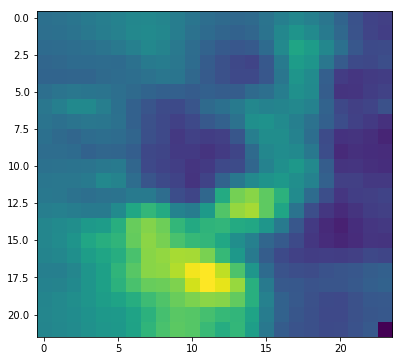

In [8]:
from matplotlib import pyplot as plt
#%matplotlib inline
plt.rcParams['figure.figsize'] = (18, 6)

layer_idx = utils.find_layer_idx(model, 'preds')
# Swap softmax with linear
#model.layers[layer_idx].activation = activations.linear
#model = utils.apply_modifications(model)

# This is the output node we want to maximize.
filter_idx = 1
input_range= (0.,1.)
img_act = visualize_activation(model, 
                               layer_idx, 
                               filter_indices=filter_idx, 
                               input_range=input_range,
                               #verbose=True,
                               tv_weight=0.2, 
                               lp_norm_weight=0.
                              )
plt.imshow(img_act[:,:,0])

In [9]:
model.layers[-1].activation

<function keras.activations.linear>

In [10]:
img_act.shape

(22, 24, 1)

In [11]:
x_train=np.load("periodic/X_train.npy")
x_test=np.load("periodic/X_test.npy")

y_train=np.load("periodic/y_train.npy")
y_test=np.load("periodic/y_test.npy")

x=np.concatenate((x_train, x_test))
y=np.concatenate((y_train, y_test))

classes=[1,2,4,5,6,8,13]
filterid={1:0,2:1,4:2,5:3,6:4,8:5,13:6}

<Figure size 1296x432 with 0 Axes>

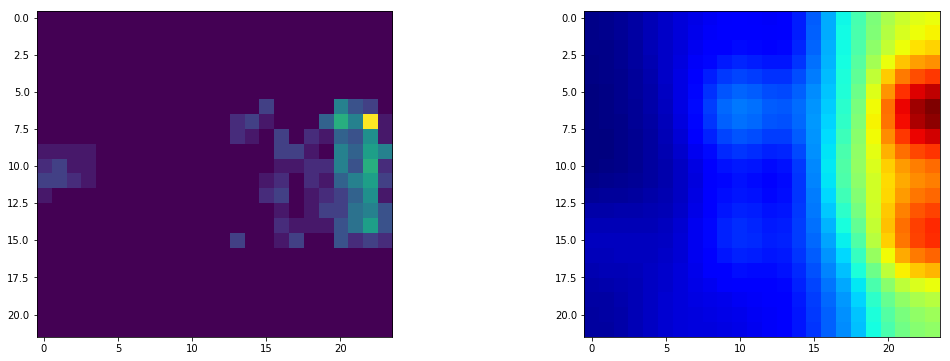

In [12]:
plt.rcParams['figure.figsize'] = (18, 6)
layer_idx = utils.find_layer_idx(model, 'preds')
penultimate_layer_idx = utils.find_layer_idx(model, 'conv2d2')
# Swap softmax with linear
#model.layers[layer_idx].activation = activations.linear
#model = utils.apply_modifications(model)


# This is the output node we want to maximize.
filter_idx = 2
#input_range= (0,255)
#image=np.random.random_sample((22,24,1))
image=x[6].transpose((1,2,0))
img_cam = visualize_cam(model, layer_idx, filter_indices=filter_idx, seed_input=image, 
                             penultimate_layer_idx=penultimate_layer_idx)
plt.figure()
fig, ax=plt.subplots(1,2)
ax[0].imshow(image[:,:,0])
ax[1].imshow(img_cam)

<Figure size 1296x432 with 0 Axes>

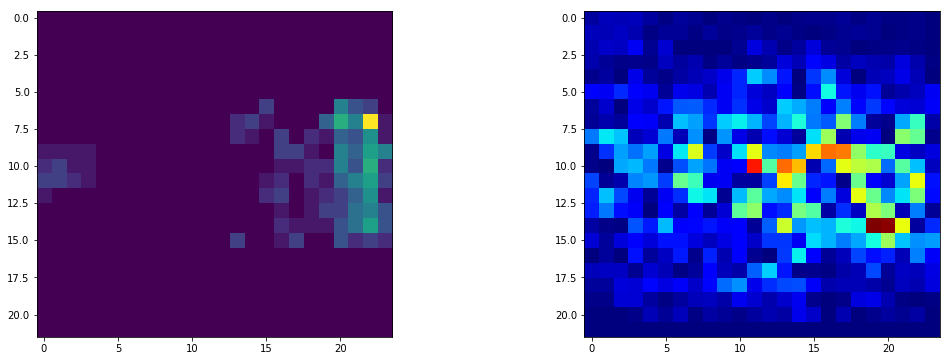

In [14]:
plt.rcParams['figure.figsize'] = (18, 6)

layer_idx = utils.find_layer_idx(model, 'preds')
penultimate_layer_idx = utils.find_layer_idx(model, 'conv2d2')
# Swap softmax with linear
#model.layers[layer_idx].activation = activations.linear
#model = utils.apply_modifications(model)

# This is the output node we want to maximize.
filter_idx = 0
#input_range= (0,255)
#image=np.random.random_sample((22,24,1))
image=x[6].transpose((1,2,0))
img_sal = visualize_saliency(model, layer_idx, filter_indices=filter_idx, seed_input=image, 
                             #penultimate_layer_idx=penultimate_layer_idx
                            )
#plt.figure()
plt.figure()
fig, ax=plt.subplots(1,2)
ax[0].imshow(image[:,:,0])
ax[1].imshow(img_sal)